# Artificial Intelligence and Machine Learning - Coursework 2 - Pratical Component - 1st diet
# Module ID : MMI226824
## Improving News Classification Using NLP
# Student Name: Arjun Paudel
# Student Email: APAUDE300@caledonian.ac.uk
# Student ID Number : S2271954
# Submission Date : 2024/01/09
I confirm that the material contained within the submitted coursework is all my own work unless otherwise stated below.

---

# CW2: Natural Language Processing: Classification of News Articles
This coursework extends Lab 8, using the content of news articles to classify them into one of the 4 following categories: `World, Sports, Business, Sci/Tech`.

The original data source is http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html. You do not need to download the data from those websites, it has been made available on GCU learn in the compressed file 'news_dataset.zip', you simply need to download and extract it. You'll get files *train.csv* and *test.csv*. Place them in the same folder as this notebook (or change the path in `pd.read_csv()` accordingly).

Import Conda environmet `lab8_NLP_news.yml`.

First necessary libraries were loaded to perform the natural language processing and text classification tasks. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

from nltk.stem import PorterStemmer



# 1. Data preparation


Follwing code is uesd to laod the data into two data frame that train data and test data.

In [2]:
# Importing the dataset. As done in lab 4, you usually have a look at the data. Here we simply show the first 5 rows
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
print(train_data.head(5))



   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


Change labels from 1-4 to 0-3

In [3]:
# substract 1 from the target variable for both, train and test data
train_data["Class Index"] = train_data["Class Index"] - 1
test_data["Class Index"] = test_data["Class Index"] - 1
label_names = ["World", "Sports", "Business", "Sci/Tech"] # 0 is "World", 1 is "Sports", ...

## Preprocessing 

Lowercase descriptions and clean up non-letter characters.

**TODO 1**: Remove the occurences of "http" "href", "https" and "www". Also, remove the names of the news agencies (Reuters, AP, ...) from the datasets.

In the following code, a fucntion is defined as a preprocess_text which deals with the cleaning and proecessing of text in both training and testing data. This function do a various tasks which are listed below.
1) First, it replace  any URL that start with either http or https that was present in the dataframe with space.
2) After examing on the data, it shows that there are few text (domain name ) which comes with the **.com** only. So these were also removed by executing the code.
3) At the starting of description columns in almost each rows, there is a name of news agency companies and location from where the news was reported. So it time to remove these words to get the better results. All the common news agency names that appear on the data were store in a variables and, in first, that location name or anything that comes before the news agency name was removed and after that the words that comes under the **news_agencies** variable were removed from the dataframe.
4) Processing data in natural language processing is case sensative, that why all the string from the dataframe is change to lower case and also replace single quotes, backslashes and non alphabetic character with spaces was done.
5) After examine on few data it show that still some html tags were present in dataframe, so it's a time to process all the tags that were present in dataframe, first store in **remove_html_tags** variable and then replace those tags with space. This step can be done after point number 3 but as it was already mentioned above that natural language processing is case sensative that means it only remove those letter that was passed through variables. In this case there is mix up on different html tag, some are in higher case and some are in lower case, that why first all the string was changed into the lower cases and **remove_html_tags** passed to replace those words with space.

Finally, **preprocess_text** fucntion is apply on both training and testing data in description columns only to get the clean data.

In [4]:
# Function to preprocess the data
def preprocess_text(string):
    # TODO 1: REMOVE http (html, ...) and news agencies names (Reuters, AP, ...)

     # Removing URLs having http and https
    
    string = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', string)
    
    # Removing any text with website names (.com)
    string = re.sub(r'\S*\.com\S*', ' ', string)

    # Removing any text before news agencies names
    news_agencies = ['Reuters','AP','CNN','AFP','CP']  
    string = re.sub(fr'.*?({"|".join(news_agencies)})', r'\1', string)

    # Removing news agency name 
    for agency_name in news_agencies:
     string = string.replace(agency_name, '')

    # Converting entire string to lowercase and replace single quotes, backslashes and non alphabetic character with spaces
    string = string.lower()
    string = string.replace("'", " ")
    string = string.replace("\\", " ")
    string = re.sub(r"[^a-zA-Z]", " ", string)


     # Removing html tags from entire string in dataframe
    remove_html_tags = ['http','https', 'href', 'www','quot', 'lt', 'html']
    for html_tags  in remove_html_tags:
     string = string.replace(html_tags, '')
     
    return string
train_data["Description"] = train_data["Description"].apply(preprocess_text)
test_data["Description"] = test_data["Description"].apply(preprocess_text)

Convert dataframes to lists (needed for further functions).

In [5]:
train_data_list = train_data["Description"].tolist()
test_data_list = test_data["Description"].tolist()
train_labels_list = train_data["Class Index"].tolist()
test_labels_list = test_data["Class Index"].tolist()

Create validation set (taking out 20% of test set)

In [6]:
(train_data_list, validation_data_list,
 train_labels_list, validation_labels_list) = train_test_split(train_data_list, train_labels_list, test_size=0.2, stratify=train_labels_list)

### Removing Stop Words
Remove stopwords from the *stopword* corpus.

In [7]:
nltk.download("stopwords")
def remove_stopwords(data_list):
    stopword_list = stopwords.words("english")
    for i in range(len(data_list)):
        data_list[i] = " ".join(
            [word for word in data_list[i].split() if word not in (stopword_list)]
        )
    return data_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
train_data_list = remove_stopwords(train_data_list)
validation_data_list = remove_stopwords(validation_data_list)
test_data_list = remove_stopwords(test_data_list)

### TODO 2: STEMMING
Use **Stemming** or **Lemmatization** to grammatical word variations.

For simplifying grammatical word variation, stemming technique is used over here. Stemming is a technique used to reduce words to their base form know as stem. For example, after applying a stemming on a word like 'running','runner' and 'ran' , it would changed into 'run'.

To perform stemming, **PoterStemmer** was imported from the Natural Language Toolkit(nltk) library (Which is already define in import section on the stating of report). In the follwing cell, the code define a **'stem_list'** function that take a list of words that is **'word_list'** as a input and applies steamming to each word using the PorterStemmer. 

In [9]:
# TODO 2: 

#Applying stemming to simplify grammatical word variations

stemmer = PorterStemmer()
def stem_list(word_list):
    return [stemmer.stem(word) for word in word_list]



In [10]:
train_data_list = stem_list(train_data_list)
validation_data_list = stem_list(validation_data_list)
test_data_list = stem_list(test_data_list)

## 2. Recurrent Neural Network classifier with Keras and Tensorflow

One-hot encode the labels (0 -> 0001, 1 -> 0010, ...) to match NN classifier head output.

In [11]:
# the labels are of value 0, 1, 2, 3. We need to convert them to one-hot encoded vectors 
train_labels = tensorflow.keras.utils.to_categorical(np.array(train_labels_list), num_classes=4)
validation_labels = tensorflow.keras.utils.to_categorical(np.array(validation_labels_list), num_classes=4)
test_labels = tensorflow.keras.utils.to_categorical(np.array(test_labels_list), num_classes=4)
print(train_labels.shape)

(96000, 4)


First we use the TextVectorization layer to convert the text to a sequence of integers. You can read about how this works  [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).


In [12]:
# this will create a vocabulary of the top 2500 words and then convert the text to a sequence of numbers
vocab_size = 2500 # how many of the most frequent words to keep
sequence_length = 30 # how many words we use to represent a description
vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)
# fit the vectorizer on the training data (find the most common words and assign values to them)
vectorizer.adapt(train_data_list)
# show the selected words
print(vectorizer.get_vocabulary())

['', '[UNK]', 'said', 'new', 'year', 'us', 'two', 'first', 'wednesday', 'monday', 'world', 'tuesday', 'thursday', 'one', 'company', 'friday', 'gt', 'inc', 'u', 'last', 'yesterday', 'three', 'president', 'week', 'million', 'corp', 'oil', 'sunday', 'would', 'united', 'today', 'time', 'government', 'game', 'people', 'could', 'second', 'group', 'saturday', 'season', 'iraq', 'next', 'night', 'third', 'day', 'years', 'percent', 'software', 'york', 'security', 'microsoft', 'team', 'prices', 'stocks', 'minister', 'internet', 'quarter', 'market', 'four', 'back', 'announced', 'high', 'international', 'state', 'billion', 'month', 'may', 'top', 'n', 'win', 'former', 'officials', 'news', 'record', 'end', 'open', 'states', 'european', 'business', 'largest', 'city', 'american', 'report', 'victory', 'federal', 'says', 'prime', 'e', 'network', 'league', 'computer', 'washington', 'killed', 'five', 'home', 'national', 'technology', 'country', 'according', 'co', 'service', 'bush', 'say', 'research', 'chin

In [13]:
# vectorize the training data (replace words by their associated values)
train_data_vectorized = vectorizer(train_data_list)
# vectorize the validation data
validation_data_vectorized = vectorizer(validation_data_list)
# vectorize the test data
test_data_vectorized = vectorizer(test_data_list)
# this shape shows that we have our 96000 training examples, each as a vector of 30 integers
print(train_data_vectorized.shape)

(96000, 30)


In [14]:
# see how a vectorized news description looks like
print(train_data_vectorized[1])

tf.Tensor(
[2463    1    1    1  599  558 2238 1627    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)


We then build a RNN.

We use an *Embedding layer* to convert the integer sequences to embeddings. You can read about how this works [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

The Bidirectional layer takes the input and passes it forwards and backwards through the LSTM (Long-Short Term Memory) layer. It allows the network to learn the context of the sentence in both directions, so information from both previous and following words is taken into account.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          80000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 96,900
Trainable params: 96,900
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
750/750 [==============================] - 13s 14ms/step - loss: 0.4826 - accuracy: 0.8238 - val_loss: 0.3599 - val_accuracy: 0.8745
Epoch 2/5
750/750 [==============================] - 9s 12ms/step - loss: 0.3346 - accuracy: 0.8834 - val_l

<Axes: >

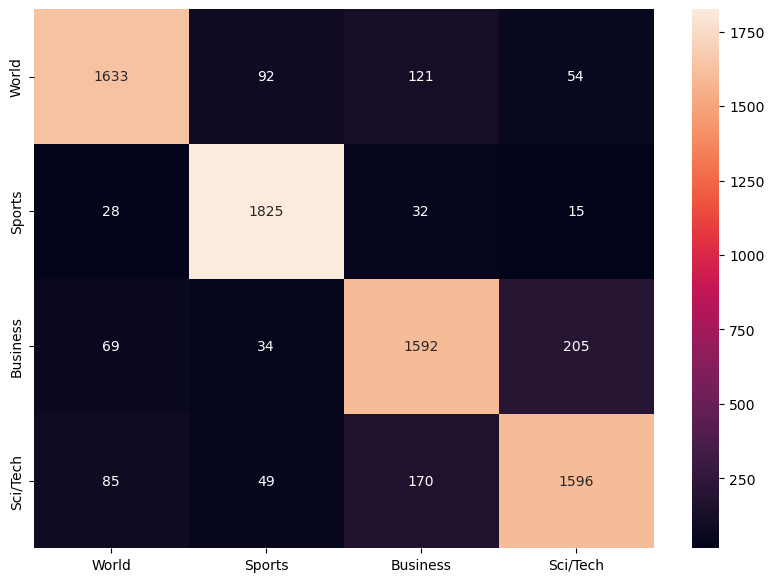

In [15]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(4, activation="softmax"))

model.summary()

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# predict the labels on the test data
rnn_predictions = model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
rnn_predictions = np.argmax(rnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, rnn_predictions)
print("Test Set Accuracy: ", accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

# TODO 3: Creating Example Predictions
Test the model. Create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels. Use one example per class.

Also, find one example that gets misclassified and briefly discuss here why it might happen:

Here five different labels sample news from different news site  was passed trough a model, to check whether model can predict the right or not. Among five, four of sample news was correctly predict by the model. But the last news which was from bbc business news label, model predict it as it from Science and Technology label. There are various reason for misprediction of the model, which are listed below.
1) **Similar Content**: The misprediction sample news label might share the similarity with the news from the another category or label, which makes the model to challenging to distingusih between them.
2) **Unbalance Data** : While passing the training data there might be significantly more training data from the one label than another, then model is baised towards the majority label. Which may leads the model to predict the wrong label.
3) **Ambiguous Language** : Some news categories or label like business, and science and technology sometime share the multidisciplinary topic, which also another factor for misprediction. 


In [18]:
sample_news = list()
# TODO 3: create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels
# Use one example per class

# World from cnn
sample_news.append("At least 250 killed over the past 24 hours in central Gaza, Hamas-controlled health ministry says")

# Sport from cnn
sample_news.append("The 38-year-old produced an offensive masterclass as he became the first player in their 21st NBA season to record a 40-point game, going 13-for-20 from the field, including making all five of his threes. He also added seven rebounds and seven assists.")

# Bussiness news from cnn
sample_news.append("X stands accused of failing to pay out annual bonuses to staff after its October 2022 acquisition by billionaire Elon Musk – despite repeated assurances from executives in the lead-up to and following the deal that the company would do so, according to a lawsuit filed in June 2023 on behalf of employees.")

# Science and technology news from cnn
sample_news.append("Over the past year, OpenAI has cemented its place as one of the most powerful tech startups in the world.")

# Also, find one example that gets misclassified and discuss why it might happen in the markdown above.

# This news is from bbc business label but it show the result in sci/tech news
sample_news.append("A review of veterinary services in the UK needs to ensure that pricing is made clearer, a consumer body has said.")

# preprocess the sample news
sample_news = [preprocess_text(i) for i in sample_news]
sample_news = remove_stopwords(sample_news)

# If you added stemming/lemmatization, do it on sample_news as well

#stemming the sample news with the help of stem_list function that we describe above
sample_news = stem_list(sample_news)

# vectorize the sample news
sample_news_vectorized = vectorizer(sample_news)

# predict using the neural network
prediction = model.predict(sample_news_vectorized)
prediction = np.argmax(prediction, axis=1)
for i in prediction:
     print("NN classifier prediction: ", label_names[prediction[i]], "News")


1/1 [==============================] - 0s 21ms/step
NN classifier prediction:  World News
NN classifier prediction:  Sports News
NN classifier prediction:  Business News
NN classifier prediction:  Sci/Tech News
NN classifier prediction:  Sci/Tech News


## TODO 4: Create a new model
Try to improve the RNN model, of implement a CNN (with 1D convolution layers), that beats the baseline RNN

As we see on the before, while predicting the sample news, model has predict the some news as misclassified. So to overcome this challenge and make the mode more productive, we try to imporve our model by implementing a CNN( with 1D concolution layers) which beats the baseline RNN and predict more precisely.
Conv1D layers helps to capture the local patterns and features in the sequential data. It helps to identify important motifs or structure that might be relevant for classification. Another GlobalMaxPooling1D layer reduces the spatial dimension of the convolutional output and helps to focusing on the most important feature from the training data. 
In overall addition of Conv1D, GlobalMaxPooling1D helps to makes the model suitable for capturing sequential patterns and predict more accuracy.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          80000     
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         16640     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, None, 64)          20544     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 4)                

<Axes: >

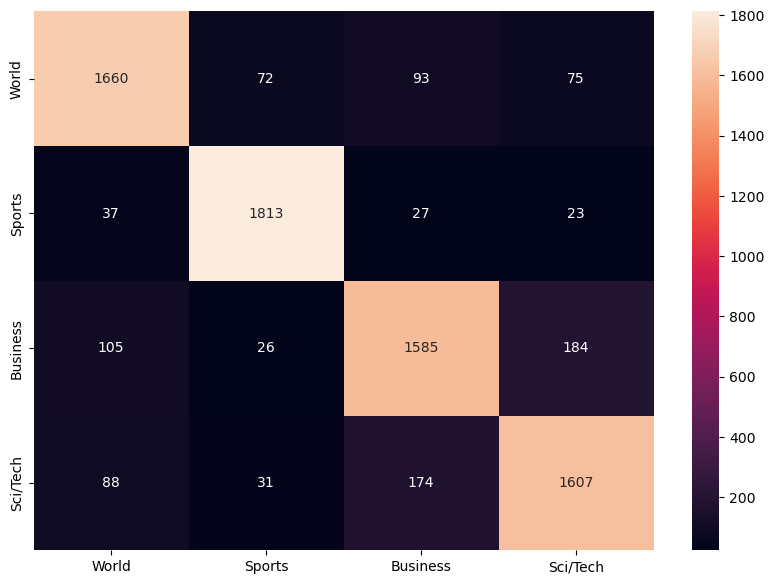

In [17]:
# TODO 4: YOUR CODE HERE

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Print the model summary
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels)
)

# Predict the labels on the test data
cnn_predictions = model.predict(test_data_vectorized)
cnn_predictions = np.argmax(cnn_predictions, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(test_labels_list, cnn_predictions)
print("Test Set Accuracy: ", accuracy)

# Create a confusion matrix
cm = confusion_matrix(test_labels_list, cnn_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)


## TODO 5: Discussion how step from 1 to 4 helps to improve the performance.


Those steps that we take form 1 to 4, obviously improve the performace. Just a quick reminder in step 1 all the unwanted words (News agency name, and location from where the news was taken) and website link (all the resuidal html code, and link that has having .com in last) was removed. In step 2, stemming features was passed through the data for simplyfying the grammatical word variations. In step 3, some news sample was passed through different news agency with different label, and some of the news was wrongly predicted by the model. Then in step 4, to make the model more precise CNN (with 1D convolution layers) was added to the model layer which helps to capture the local patterns and features in the sequential data. 
Through these each step the prediction of model, also become more accurate. At first if those residual words was not removed from the dataframe then they will create a baised on the model. As model get trained from the data and if it received the same data or same html link for different news label then it will predict wrongly. Also through the second step, if the words are gramatically correct, then it will be more flexible for model to understand the training data. In step three, it just a prediction where model is working good or bad through sample news. But in Step four model was subjected with more layer for natural language processing which helps to understand the training data by going on depth.
In overall these four step helps the model to improve the performace.

--- 
Sources:
- What is Natural Language Processing (NLP) : https://www.ibm.com/topics/natural-language-processing
- An Introduction to Stemming in Natural Language Processing : https://www.analyticsvidhya.com/blog/2021/11/an-introduction-to-stemming-in-natural-language-processing/
- Natural Language Processing : https://keras.io/examples/nlp/
- NLP - Data Preprocessing and Cleaning: https://www.kaggle.com/code/colearninglounge/nlp-data-preprocessing-and-cleaning